# ResNet50_Face_Emotion_Detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [4]:
train_dir = '/content/drive/MyDrive/objectsforblind/train'
val_dir = '/content/drive/MyDrive/objectsforblind/test'

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

Found 6873 images belonging to 35 classes.
Found 1707 images belonging to 35 classes.


In [6]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [7]:
obj_model = Sequential()
obj_model.add(base_model)
obj_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3), data_format='channels_last'))
obj_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
obj_model.add(MaxPooling2D(pool_size=(2, 2)))
obj_model.add(Dropout(0.25))
obj_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
obj_model.add(MaxPooling2D(pool_size=(2, 2), padding='same',))
obj_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
obj_model.add(MaxPooling2D(pool_size=(2, 2), padding='same',))
obj_model.add(Dropout(0.25))
obj_model.add(Flatten())
obj_model.add(Dense(1024, activation='relu'))
obj_model.add(Dropout(0.5))
obj_model.add(Dense(35, activation='softmax'))

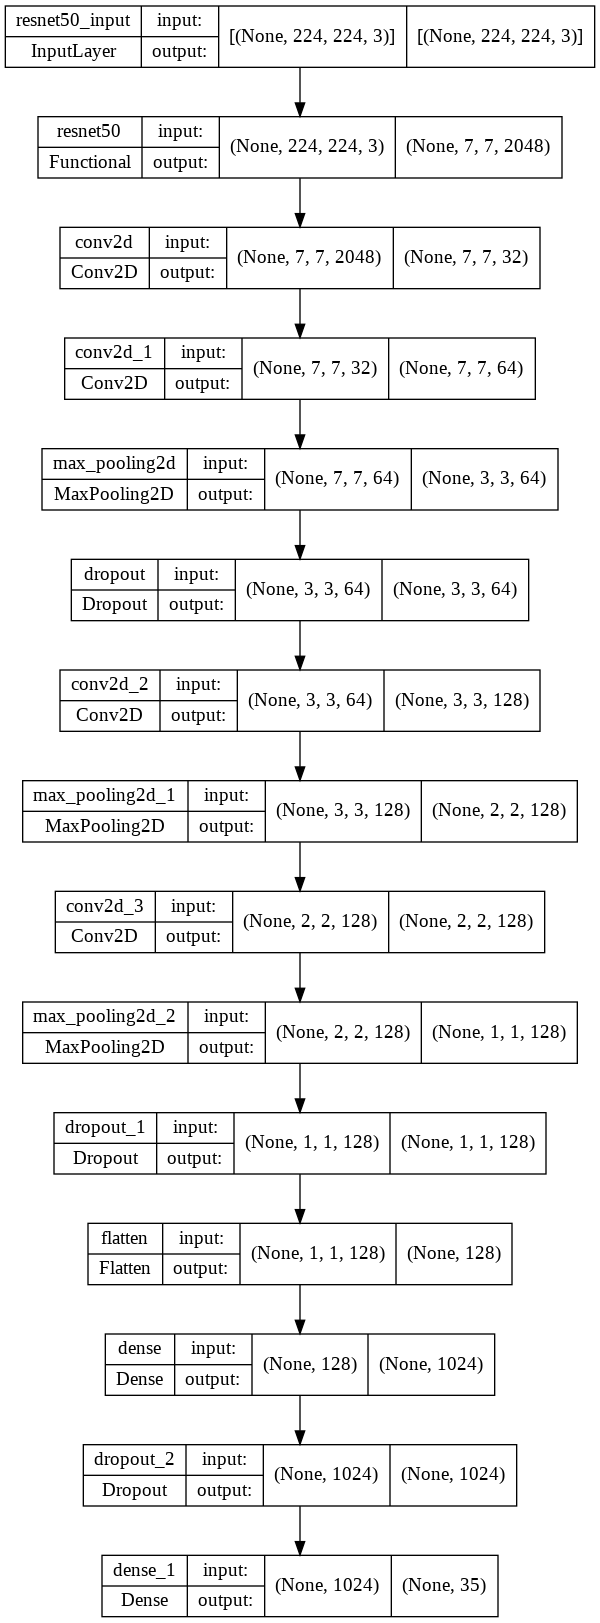

In [8]:
plot_model(obj_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
obj_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          589856    
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                        

In [10]:
obj_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [11]:
obj_model_info = obj_model.fit_generator(
        train_generator,
        steps_per_epoch=6873 // 64,
        epochs=35,
        validation_data=validation_generator,
        validation_steps=1707 // 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/35
  9/107 [=>............................] - ETA: 32:52 - loss: 0.4446 - accuracy: 0.0347

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


107/107 [==============================] - 3007s 28s/step - loss: 0.1711 - accuracy: 0.0937 - val_loss: 0.1377 - val_accuracy: 0.0240
Epoch 2/35
107/107 [==============================] - 400s 4s/step - loss: 0.0825 - accuracy: 0.4343 - val_loss: 0.2143 - val_accuracy: 0.0835
Epoch 3/35
107/107 [==============================] - 397s 4s/step - loss: 0.0407 - accuracy: 0.7678 - val_loss: 0.2276 - val_accuracy: 0.0986
Epoch 4/35
107/107 [==============================] - 405s 4s/step - loss: 0.0195 - accuracy: 0.9078 - val_loss: 0.2582 - val_accuracy: 0.1743
Epoch 5/35
107/107 [==============================] - 408s 4s/step - loss: 0.0099 - accuracy: 0.9662 - val_loss: 0.4453 - val_accuracy: 0.2368
Epoch 6/35
107/107 [==============================] - 402s 4s/step - loss: 0.0056 - accuracy: 0.9825 - val_loss: 0.3461 - val_accuracy: 0.4237
Epoch 7/35
107/107 [==============================] - 397s 4s/step - loss: 0.0046 - accuracy: 0.9881 - val_loss: 0.1950 - val_accuracy: 0.6743
Epoch 8/

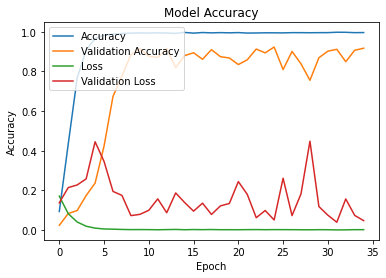

In [12]:
from matplotlib import pyplot as plt
plt.plot(obj_model_info.history['accuracy'])
plt.plot(obj_model_info.history['val_accuracy'])
plt.plot(obj_model_info.history['loss'])
plt.plot(obj_model_info.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"],loc='upper left')
plt.show()

In [24]:
#Saving the model
obj_model.save('objdetectionmodel.h5')


In [1]:
from keras.models import load_model
obj_model = load_model('objdetectionmodel.h5')

In [2]:
!pip install pyttsx3
!pip install gTTS

In [3]:
import pandas as pd
import pyttsx3
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio
from gtts import gTTS
def obj_analysis(obj):
    objects = ('1 Taka','10 Taka','100 Taka','1000 Taka', '2 Taka','20 Taka', '5 Taka',  '50 Taka', '500 Taka', 'Person',  'bed', 'bicycle', 'bike', 'boat', 'bus','c-n-g', 'car', 'chair', 'desk', 'door', 'easy-bike', 'horse-cart', 'laptop', 'launch', 'leguna', 'lorry', 'mug', 'rickshaw', 'stair', 'television', 'thelagari', 'tractor', 'truck', 'van', 'window')
    a=objects[obj]
    print(a)
           #Import Audio method from IPython's Display Class
    tts = gTTS(a) #Provide the string to convert to speech
    tts.save('1.wav') #save the string converted to speech as a .wav file
    #y_pos = np.arange(len(objects))
    return a
    #plt.bar(y_pos, obj, align='center', alpha=0.5)
    #plt.xticks(y_pos, objects)
    #plt.ylabel('percentage')
    #plt.title('Object')
    
    #plt.show()

In [4]:
!pip install Js2Py

In [5]:
from IPython.display import display, Javascript
from js2py import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [6]:
#take_photo()

max value in array:  1.0
max value index:  9
Person


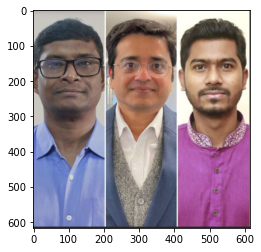

In [7]:
import cv2

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = 'photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="rgb", target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = obj_model.predict(x)
maxVal_Index = np.argmax(custom)
print('max value in array: ', np.amax(custom))
print('max value index: ', maxVal_Index)


a=obj_analysis(maxVal_Index)

x = np.array(x, 'float32')
x = x.reshape([224, 672]);


plt.imshow(true_image)
plt.show()

In [8]:
sound_file = '1.wav'
Audio(sound_file, autoplay=True) 

In [9]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [10]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    a=objects[emotions]
    print(a)
           #Import Audio method from IPython's Display Class
    tts = gTTS(a) #Provide the string to convert to speech
    tts.save('2.wav') #save the string converted to speech as a .wav file
  

In [11]:
def facecrop(image):  
    facedata = 'haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

In [12]:
import cv2
            


   
def emotion_obj():

    if __name__ == '__main__':
        facecrop('photo.jpg')

    #Testing a file.

    from keras.preprocessing import image
    from keras.preprocessing.image import ImageDataGenerator

    import numpy as np
    import matplotlib.pyplot as plt

    
    file = 'capture.jpg'
    true_image = image.load_img(file)
    img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom1 = emotion_model.predict(x)
    maI = np.argmax(custom1)
    print('max value in array: ', np.amax(custom1))
    print('max value index: ', maI)

    emotion_analysis(maI)

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);


    plt.imshow(true_image)
    plt.show()

max value in array:  0.8496414
max value index:  4
sad


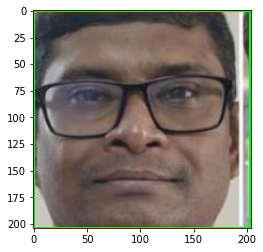

In [13]:
if a=="Person":
        emotion_obj()
    

In [15]:
sound_file = '2.wav'
Audio(sound_file, autoplay=True) 